In [205]:
import pandas as pd 
import numpy as np
import math , sys
import matplotlib.pyplot as plt 
from sklearn.neighbors  import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error ,r2_score
from sklearn.dummy import DummyRegressor

plt.rc('font',size=18)
plt.rcParams['figure.constrained_layout.use'] = True 
plt.rcParams.update({'font.size':22})
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.7
#%matplotlib inline

In [5]:
pearse =pd.read_csv("pearseProcessed.csv",usecols=[0,1,3],parse_dates=[0])
portobello = pd.read_csv("portobelloProcessed.csv",usecols=[0,1,3],parse_dates=[0])

In [6]:
def convertDays(df):
    convertSec = 1000000000
    # tFull = pd.array(pd.DatetimeIndex(df.iloc[:,0]).astype(np.int64))/convertSec
    tFull = ((pd.DatetimeIndex(df.iloc[:,0]).astype(np.int64))/convertSec).values
    dt = tFull[1] -tFull[0]
    print(dt)

    t = (tFull-tFull[0]) /60 /60/24
    #df.iloc[:,4]=t.tolist()
    return t ,dt  

In [7]:
secondsPearse,dt = convertDays(pearse)
pearse['days']=secondsPearse.tolist()
portobello['days']= secondsPearse.tolist()

300.0


C:\Users\brosn\AppData\Local\Temp/ipykernel_9068/231375872.py:4: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  tFull = ((pd.DatetimeIndex(df.iloc[:,0]).astype(np.int64))/convertSec).values


In [9]:
lag = 3
y = portobello.iloc[:,1]
t = portobello.iloc[:,3]
qVal=[2,6,12]

,TIME,AVAILABLE BIKES,dataType,days
0,2020-01-28 00:00:02,0,wday,0.000000
1,2020-01-28 00:05:02,0,wday,0.003472
2,2020-01-28 00:10:02,0,wday,0.006944
3,2020-01-28 00:15:02,0,wday,0.010417
4,2020-01-28 00:20:02,0,wday,0.013889
...,...,...,...,...
12379,2020-03-10 23:35:02,11,wday,42.982639
12380,2020-03-10 23:40:02,11,wday,42.986111
12381,2020-03-10 23:45:02,11,wday,42.989583
12382,2020-03-10 23:50:02,11,wday,42.993056


All variables to be used declared 

In [11]:
def BuildModel(q,y,t):
    stride=1
    q=6
    w=math.floor(7*24*60*60/dt) # number of samples per week
    len =y.size-w-lag*w-q
    XX=y[q:q+len:stride]
    for i in range(1,lag):
        X=y[i*w+q:i*w+q+len:stride]
        XX=np.column_stack((XX,X))

    d=math.floor(24*60*60/dt) # number of samples per day

    for i in range(0,lag):
        X=y[i*d+q:i*d+q+len:stride]
        XX=np.column_stack((XX,X))

    for i in range(0,lag):
        X=y[i:i+len:stride]
        XX=np.column_stack((XX,X))

    yy=y[lag*w+w+q:lag*w+w+q+len:stride]
    tt=t[lag*w+w+q:lag*w+w+q+len:stride]

    yy.reset_index(drop=True, inplace=True)
    tt.reset_index(drop=True, inplace=True)
    return tt,yy,XX

In [195]:
def KnnModel2(q,bikes,time):
    tt,yy,XX = BuildModel(q,bikes,time)
    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2) 
    mse =[];std=[];temp=[]
    cv = TimeSeriesSplit(n_splits=5)
    for k in range(1,20):
        for train,test in cv.split(XX):
            model = KNeighborsRegressor(n_neighbors=k,weights='distance').fit(XX[train],yy[train])
            yPred = model.predict(XX[test])
        temp.append(mean_squared_error(yPred,yy[test]))
        mse.append(np.array(temp).mean())
        std.append(np.array(temp).std())
    #print("MSE".)    
    return mse ,std

In [197]:
def KnnModel1(q,bikes,time, weight):
    tt,yy,XX = BuildModel(q,bikes,time)
    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2) 
    MSE =[]; meanE=[];stdE=[]
    temp =[]; meanETrain =[]; stdETrain=[]
    cv = TimeSeriesSplit(n_splits=5)
    for k in range(1,20):
        for train,test in cv.split(XX):
            model = KNeighborsRegressor(n_neighbors=k,weights=weight).fit(XX[train],yy[train])
            yPred = model.predict(XX[test])
            yPredTrain = model.predict(XX[train])
            yp2 =np.rint(yPred)
            MSE.append(mean_squared_error(yp2,yy[test]))
            temp.append(mean_squared_error(yPredTrain,yy[train]))
        meanE.append(np.array(np.sqrt(MSE)).mean())
        meanETrain.append(np.array(np.sqrt(temp)).mean())
        #print(meanE)
        stdE.append(np.array(np.sqrt(MSE)).std())
        stdETrain.append(np.array(np.sqrt(temp)).std())
    return meanE,stdE,meanETrain,stdETrain
  

REGULAR KNN MODEL DOES NOT USE CROSS VALIDATION

In [103]:
def KnnModel(q,bikes,time,weight):
    tt,yy,XX = BuildModel(q,bikes,time)
    train, test = train_test_split(np.arange(0,yy.size),test_size=0.2) 
    mse =[];std=[];temp=[]
    print("MSE HERE SHOULD BE EMPTY",mse)
    for k in range(1,20):
        model = KNeighborsRegressor(n_neighbors=k,weights=weight).fit(XX[train],yy[train])
        yPred = model.predict(XX[test])
        temp.append(mean_squared_error(yPred,yy[test]))
        mse.append(np.array(temp).mean())
        std.append(np.array(temp).std())
    #print("MSE".)    
    return mse ,std

In [105]:
def plotKnnCV(title,mse10,std10,mse30,std30,mse1,std1):

    plt.errorbar(range(1,30),mse10,yerr=std10,fmt="-o",ecolor="b",capsize=5)
    plt.errorbar(range(1,30),mse30,yerr=std30,fmt="-o",ecolor="r",capsize=5)
    plt.errorbar(range(1,30),mse1,yerr=std1,fmt="-o",ecolor="y",capsize=5)
    plt.title(title,size=20 )
    plt.legend(["10 Minutes","30 Minutes","1 hour"],loc='upper right')
    plt.xlabel('K Neighbours',size=15)
    plt.ylabel("MSE ",size=15)
    plt.rcParams['figure.figsize']=[12,5]

In [241]:
def printCrossEval(m10,std10,m30,std30,mean1,std1,m0,s0,m1,s1,m2,s2,alpha,TITLE):
    plt.title(TITLE,size=30)
    plt.rcParams['figure.figsize']=[15,6]
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)
    plt.xlabel("k neighbours",size=25)
    plt.ylabel(" MSE ",size=25)
    plt.errorbar(alpha,m10,yerr=std10,fmt="-o",ecolor="r",capsize=5)
    plt.errorbar(alpha,m30,yerr=std30,fmt="-o",ecolor="b",capsize=8)
    plt.errorbar(alpha,mean1,yerr=std1,fmt="-o",ecolor="g",capsize=10)
    ## plot training results 
    plt.errorbar(alpha,m0,yerr=s0,fmt="-o",ecolor="r",capsize=5)
    plt.errorbar(alpha,m1,yerr=s1,fmt="-o",ecolor="b",capsize=8)
    plt.errorbar(alpha,m2,yerr=s2,fmt="-o",ecolor="g",capsize=10)
    plt.legend(["10m test predictions","30m test predictions","1h test predictions","10m train predictions","30m train predictions","1h train predictions "],loc='lower right',fontsize=20)
 

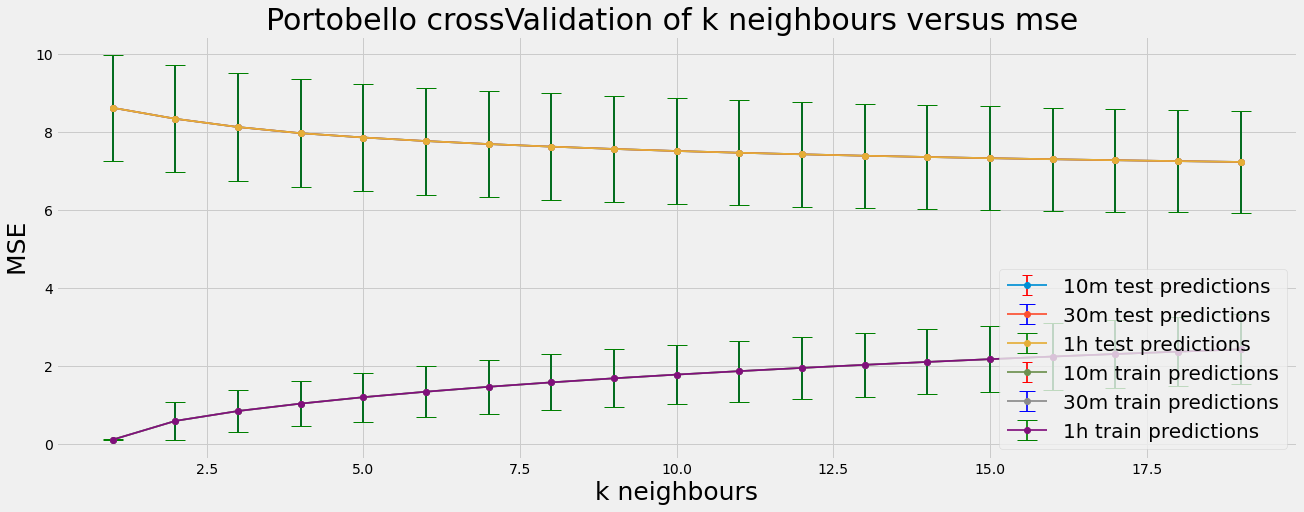

In [200]:
weight ='uniform'
title= "Portobello crossValidation of k neighbours versus mse "

meanE0,stdE0,m0,s0  =   KnnModel1(qVal[0],y,t,weight)
meanE1,stdE1,m1,s1  = KnnModel1(qVal[1],y,t,weight)
meanE2,stdE2,m2,s2= KnnModel1(qVal[2],y,t,weight)
kRange = range(1,20)
printCrossEval(meanE0,stdE0,meanE1,stdE1,meanE2,stdE2,m0,s0,m1,s1,m2,s2,kRange,title)

In [175]:
weight

'distance'

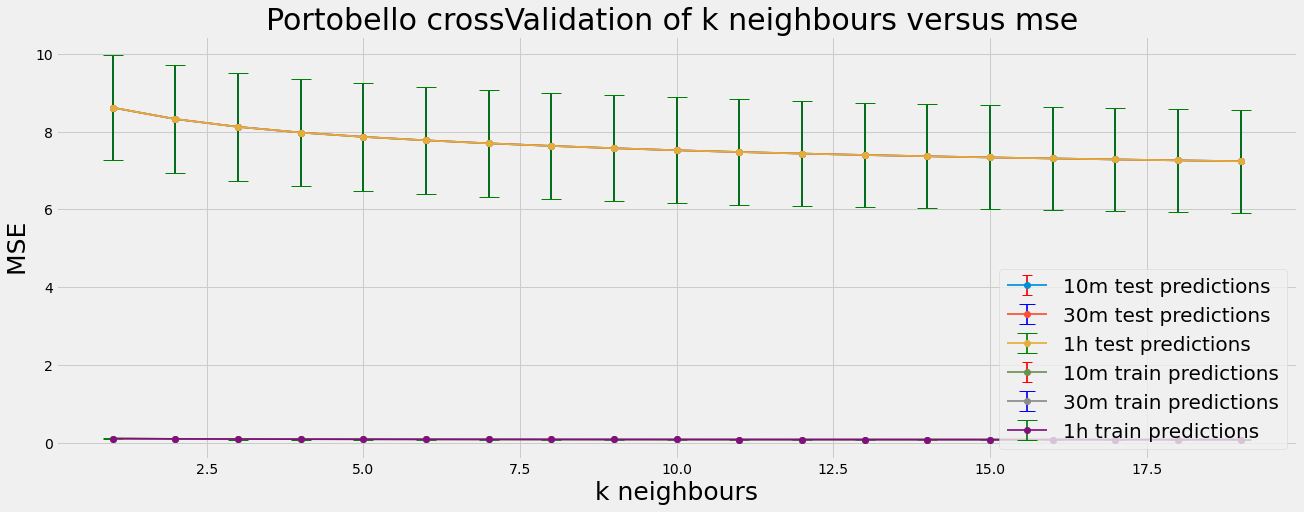

In [176]:
weightD ='distance'
title= "Portobello crossValidation of k neighbours versus mse "

meanE0,stdE0,m0,s0  =   KnnModel1(qVal[0],y,t,weightD)
meanE1,stdE1,m1,s1  = KnnModel1(qVal[1],y,t,weightD)
meanE2,stdE2,m2,s2= KnnModel1(qVal[2],y,t,weightD)
kRange = range(1,20)
printCrossEval(meanE0,stdE0,meanE1,stdE1,meanE2,stdE2,m0,s0,m1,s1,m2,s2,kRange,title)

In [169]:
print(meanE0)
print(min(meanE0))

[8.619695328059237, 8.337542382160773, 8.125539103740637, 7.967458787988351, 7.8574149175003, 7.76665767424538, 7.689192869336661, 7.622874957539037, 7.563576291610844, 7.511371930076075, 7.465753133379332, 7.426378776020129, 7.389404979688062, 7.35760239233673, 7.32670047577724, 7.300137584142233, 7.274923386006319, 7.251753933884523, 7.230479980564869]
7.230479980564869


DOES NOT USE CROSS VALIDATION 

MSE HERE SHOULD BE EMPTY []
MSE HERE SHOULD BE EMPTY []
MSE HERE SHOULD BE EMPTY []


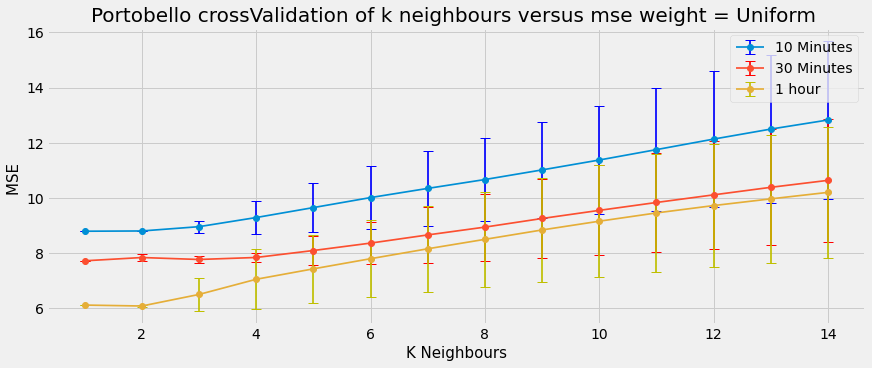

In [106]:
weight ='uniform'
title= "Portobello crossValidation of k neighbours versus mse weight = Uniform "

mse1,std1 =   KnnModel1(qVal[0],y,t,weight)
mse2 ,std2 = KnnModel1(qVal[1],y,t,weight)
mse3,std3 = KnnModel1(qVal[2],y,t,weight)

plotKnnCV(title,mse1,std1,mse2,std2,mse3,std3)

NOW DO GRIDSEARCG FOR BOTH MODELS 

In [177]:
def gridknn(q,y,t):
  tt,yy,XX = BuildModel(q,y,t)
  train, test = train_test_split(np.arange(0,yy.size),test_size=0.2,shuffle=False)

  cv =TimeSeriesSplit(n_splits=5)
  param = { 'n_neighbors' :range(1,20), #[2,3,4,5,6], #[3,5,7,9,11,13,15]
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

  search = GridSearchCV(KNeighborsRegressor(), param, scoring='r2', n_jobs=-1, cv=cv)
  result = search.fit(XX[train], yy[train])
  print('\n Best Model: \n')
  best=result.best_params_

  rd=KNeighborsRegressor(**result.best_params_).fit(XX[train], yy[train])
  y_train = yy[train]
  y_test = yy[test]
  y_hat = rd.predict(XX[train])
  y_pred = rd.predict(XX[test])

  #metrics  
  mse_tr=metrics.mean_squared_error(y_train, y_hat)
  mse_te=metrics.mean_squared_error(y_test, y_pred)
  r2_tr=metrics.r2_score(y_train, y_hat)
  r2_te=metrics.r2_score(y_test, y_pred)
  print(" Q value", q)
  print('Training set mse: ',math.sqrt(mse_tr))
  print('Test set mse: ', math.sqrt(mse_te))
  print('Training set r2: ', r2_tr)
  print('Test set r2: ', r2_te)

  return mse_tr,mse_te,r2_tr,r2_te, best,tt,y_train,y_test,y_hat,y_pred

In [178]:

y = portobello.iloc[:,1]
t = portobello.iloc[:,3]

mse_tr_q1,mse_te_q1,r2_tr_q1,r2_te_q1,best_q1,tt1,y_train,y_test,y_hat_q1,y_pred_q1=gridknn(qVal[0],y,t)
mse_tr_q2,mse_te_q2,r2_tr_q2,r2_te_q2,best_q2,tt2,y_train,y_test,y_hat_q2,y_pred_q2=gridknn(qVal[1],y,t)
mse_tr_q3,mse_te_q3,r2_tr_q3,r2_te_q3,best_q3,tt3,y_train,y_test,y_hat_q3,y_pred_q3=gridknn(qVal[2],y,t)


 Best Model: 

 Q value 2
Training set mse:  3.5232748411014745
Test set mse:  6.131948324969194
Training set r2:  0.8045644286661209
Test set r2:  0.3606610445886168

 Best Model: 

 Q value 6
Training set mse:  3.5232748411014745
Test set mse:  6.131948324969194
Training set r2:  0.8045644286661209
Test set r2:  0.3606610445886168

 Best Model: 

 Q value 12
Training set mse:  3.5232748411014745
Test set mse:  6.131948324969194
Training set r2:  0.8045644286661209
Test set r2:  0.3606610445886168


In [166]:
q1_df=pd.DataFrame.from_dict(best_q1, orient='index',columns=['q=2'])
q2_df=pd.DataFrame.from_dict(best_q2, orient='index',columns=['q=6'])
q3_df=pd.DataFrame.from_dict(best_q3, orient='index',columns=['q=12'])
df_best_rd=pd.concat([q1_df,q2_df,q3_df],axis=1)

m1_q1=pd.DataFrame(data=[mse_tr_q1,mse_te_q1,r2_tr_q1,r2_te_q1],
                   index=['mse_train','mse_test','r2_train','r2_test'],columns=['q=2'])
m2_q2=pd.DataFrame(data=[mse_tr_q2,mse_te_q2,r2_tr_q2,r2_te_q2],
                   index=['mse_train','mse_test','r2_train','r2_test'],columns=['q=6'])
m3_q3=pd.DataFrame(data=[mse_tr_q3,mse_te_q3,r2_tr_q3,r2_te_q3],
                   index=['mse_train','mse_test','r2_train','r2_test'],columns=['q=12'])
df_metrics_rd=pd.concat([m1_q1,m2_q2,m3_q3],axis=1)

df_params=pd.concat([df_best_rd,df_metrics_rd],axis=0)


In [174]:
df_params

,q=2,q=6,q=12
metric,manhattan,manhattan,manhattan
n_neighbors,19,19,19
weights,uniform,uniform,uniform
mse_train,12.413466,12.413466,12.413466
mse_test,37.60079,37.60079,37.60079
r2_train,0.804564,0.804564,0.804564
r2_test,0.360661,0.360661,0.360661


	            q=2	q=6	q=12


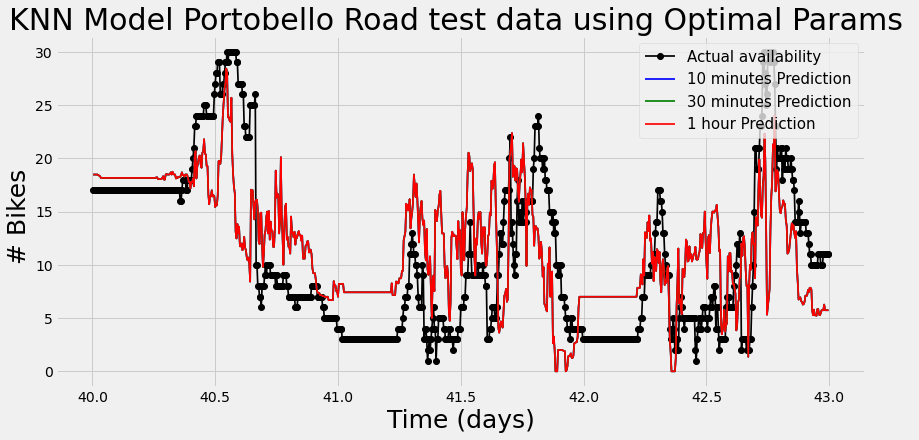

In [185]:
plt.plot(t[-len(y_test):],y_test,'-o',color='black')
plt.plot(tt1[-len(y_pred_q1):],y_pred_q1,color='blue')
plt.plot(tt2[-len(y_pred_q2):],y_pred_q2,color='green')
plt.plot(tt3[-len(y_pred_q3):],y_pred_q3,color='red')
plt.title("KNN Model Portobello Road test data using Optimal Params ",size=30)
plt.legend(["Actual availability","10 minutes Prediction","30 minutes Prediction","1 hour Prediction"],loc='upper right',fontsize=15)
#plt.xlim((4*7,4*7+5))
plt.xlabel('Time (days)',size=25)
plt.ylabel("# Bikes ",size=25)
plt.rcParams['figure.figsize']=[12,6]


KNN modelling on Pearse street data

In [186]:
bikes = pearse.iloc[:,1]
time = pearse.iloc[:,3]

In [188]:
bikes

0        30
1        30
2        30
3        30
4        30
         ..
12379    29
12380    28
12381    28
12382    28
12383    28
Name: AVAILABLE BIKES, Length: 12384, dtype: int64

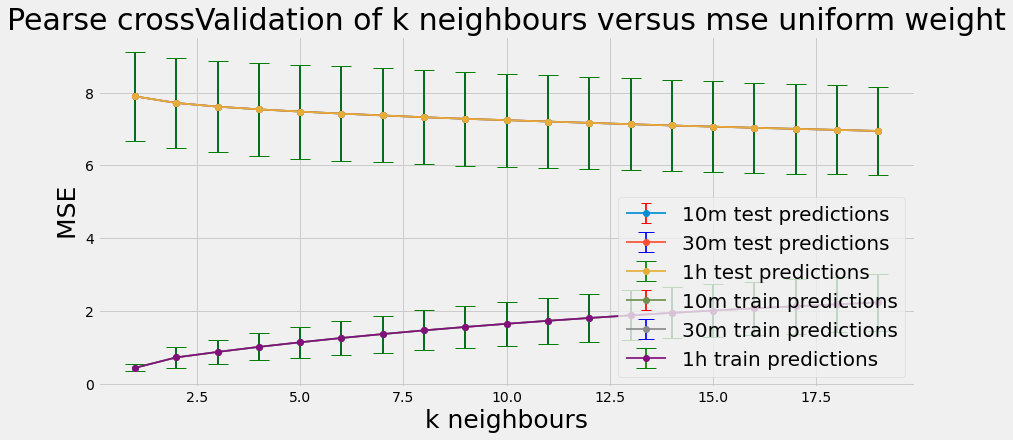

In [235]:
weight ='uniform'
title= "Pearse crossValidation of k neighbours versus mse uniform weight"

meanE0,stdE0,m0,s0  =   KnnModel1(qVal[0],bikes,time,weight)
meanE1,stdE1,m1,s1  = KnnModel1(qVal[1],bikes,time,weight)
meanE2,stdE2,m2,s2= KnnModel1(qVal[2],bikes,time,weight)
kRange = range(1,20)
printCrossEval(meanE0,stdE0,meanE1,stdE1,meanE2,stdE2,m0,s0,m1,s1,m2,s2,kRange,title)

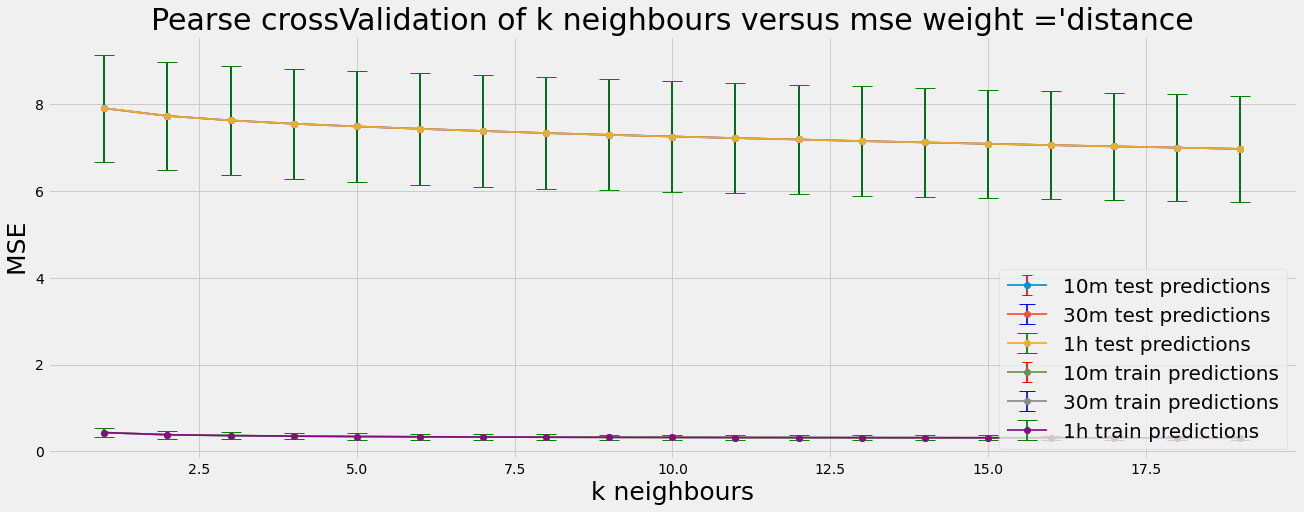

In [237]:
weight ='distance'
title= "Pearse crossValidation of k neighbours versus mse weight ='distance"

meanE0,stdE0,m0,s0  =   KnnModel1(qVal[0],bikes,time,weight)
meanE1,stdE1,m1,s1  = KnnModel1(qVal[1],bikes,time,weight)
meanE2,stdE2,m2,s2= KnnModel1(qVal[2],bikes,time,weight)
kRange = range(1,20)
printCrossEval(meanE0,stdE0,meanE1,stdE1,meanE2,stdE2,m0,s0,m1,s1,m2,s2,kRange,title)

In [199]:
mse_tr_q1,mse_te_q1,r2_tr_q1,r2_te_q1,best_q1,tt1,y_train,y_test,y_hat_q1,y_pred_q1=gridknn(qVal[0],bikes,time)
mse_tr_q2,mse_te_q2,r2_tr_q2,r2_te_q2,best_q2,tt2,y_train,y_test,y_hat_q2,y_pred_q2=gridknn(qVal[1],bikes,time)
mse_tr_q3,mse_te_q3,r2_tr_q3,r2_te_q3,best_q3,tt3,y_train,y_test,y_hat_q3,y_pred_q3=gridknn(qVal[2],bikes,time)


 Best Model: 

 Q value 2
Training set mse:  3.0767079322800366
Test set mse:  7.037567461440301
Training set r2:  0.9104983604697201
Test set r2:  0.33128474300804245

 Best Model: 

 Q value 6
Training set mse:  3.0767079322800366
Test set mse:  7.037567461440301
Training set r2:  0.9104983604697201
Test set r2:  0.33128474300804245

 Best Model: 

 Q value 12
Training set mse:  3.0767079322800366
Test set mse:  7.037567461440301
Training set r2:  0.9104983604697201
Test set r2:  0.33128474300804245


In [201]:
q1_df=pd.DataFrame.from_dict(best_q1, orient='index',columns=['q=2'])
q2_df=pd.DataFrame.from_dict(best_q2, orient='index',columns=['q=6'])
q3_df=pd.DataFrame.from_dict(best_q3, orient='index',columns=['q=12'])
df_best_rd=pd.concat([q1_df,q2_df,q3_df],axis=1)

m1_q1=pd.DataFrame(data=[mse_tr_q1,mse_te_q1,r2_tr_q1,r2_te_q1],
                   index=['mse_train','mse_test','r2_train','r2_test'],columns=['q=2'])
m2_q2=pd.DataFrame(data=[mse_tr_q2,mse_te_q2,r2_tr_q2,r2_te_q2],
                   index=['mse_train','mse_test','r2_train','r2_test'],columns=['q=6'])
m3_q3=pd.DataFrame(data=[mse_tr_q3,mse_te_q3,r2_tr_q3,r2_te_q3],
                   index=['mse_train','mse_test','r2_train','r2_test'],columns=['q=12'])
df_metrics_rd=pd.concat([m1_q1,m2_q2,m3_q3],axis=1)

df_params=pd.concat([df_best_rd,df_metrics_rd],axis=0)

In [203]:
df_params

,q=2,q=6,q=12
metric,minkowski,minkowski,minkowski
n_neighbors,19,19,19
weights,uniform,uniform,uniform
mse_train,9.466132,9.466132,9.466132
mse_test,49.527356,49.527356,49.527356
r2_train,0.910498,0.910498,0.910498
r2_test,0.331285,0.331285,0.331285


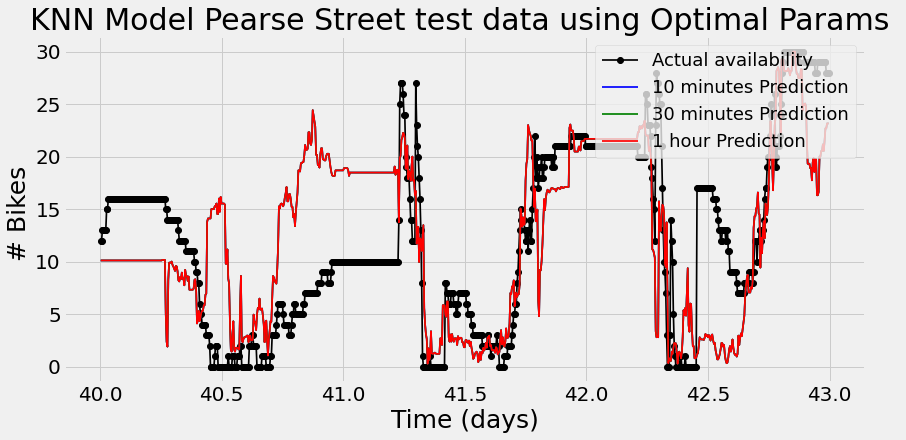

In [247]:
plt.plot(t[-len(y_test):],y_test,'-o',color='black')
plt.plot(tt1[-len(y_pred_q1):],y_pred_q1,color='blue')
plt.plot(tt2[-len(y_pred_q2):],y_pred_q2,color='green')
plt.plot(tt3[-len(y_pred_q3):],y_pred_q3,color='red')
plt.title("KNN Model Pearse Street test data using Optimal Params ",size=30)
plt.legend(["Actual availability","10 minutes Prediction","30 minutes Prediction","1 hour Prediction"],loc='upper right',fontsize=18)
#plt.xlim((4*7,4*7+5))
plt.xlabel('Time (days)',size=25)
plt.ylabel("# Bikes ",size=25)
plt.rcParams['figure.figsize']=[12,6]

In [244]:
def Baseline(bikesV,timeV):


    ## try implement a baseline that just predicts a random nu m
    for i in qVal:
        tt,yy,XX = BuildModel(i,bikesV,timeV)
        train, test = train_test_split(np.arange(0,yy.size),test_size=0.2,shuffle=False)
        MSE =[];trainMse=[];r2=[];r2Train=[]
        dummyReg = DummyRegressor(strategy="mean")
      
       
        dummyReg.fit(XX[train],yy[train])
        yPred =dummyReg.predict(XX[test])
        yPredTrain = dummyReg.predict(XX[train])


        MSE.append(mean_squared_error(yPred,yy[test]))
        trainMse.append(mean_squared_error(yPredTrain,yy[train]))
        r2.append(r2_score(yPred,yy[test]))
        r2Train.append(r2_score(yPredTrain,yy[train]))


        print("For q ",i)
        print("MSE for test data",np.sqrt(MSE))
        print("MSE for the training data",np.sqrt(trainMse))

        print("R2 score test data",r2)
        print("R2 score training data",r2Train)

In [245]:
Baseline(bikes,time)
print("----------------------------")
print("Potobello data ")
Baseline(y,t)


For q  2
MSE for test data [8.63738247]
MSE for the training data [10.2842062]
R2 score test data [-5.910767622674962e+30]
R2 score training data [-3.724248204658796e+30]
For q  6
MSE for test data [8.63738247]
MSE for the training data [10.2842062]
R2 score test data [-5.910767622674962e+30]
R2 score training data [-3.724248204658796e+30]
For q  12
MSE for test data [8.63738247]
MSE for the training data [10.2842062]
R2 score test data [-5.910767622674962e+30]
R2 score training data [-3.724248204658796e+30]
----------------------------
Potobello data 
For q  2
MSE for test data [7.67152552]
MSE for the training data [7.96975033]
R2 score test data [0.0]
R2 score training data [0.0]
For q  6
MSE for test data [7.67152552]
MSE for the training data [7.96975033]
R2 score test data [0.0]
R2 score training data [0.0]
For q  12
MSE for test data [7.67152552]
MSE for the training data [7.96975033]
R2 score test data [0.0]
R2 score training data [0.0]
